In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(
    Measurement.date
).order_by(
    Measurement.date.desc()
).first()[0]

last_date= dt.datetime.strptime(last_date,"%Y-%m-%d")

# Calculate the date one year from the last date in data set

first_date = last_date - dt.timedelta(days = 365)
# first = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# print(first) 

# Perform a query to retrieve the data and precipitation scores

twelve_month_data = session.query(
    Measurement.date,
    Measurement.prcp
).filter(
    Measurement.date > first_date
).order_by(
    Measurement.date
).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

prcp_date_df = pd.DataFrame(twelve_month_data,columns = ['date','precipitation'])
prcp_date_df['date'] = pd.to_datetime(prcp_date_df['date'])
prcp_date_df.set_index(prcp_date_df['date'],inplace = True)
prcp_date_df.head()


,date,precipitation
date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,2.15
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,NaN
2016-08-24,2016-08-24,1.22


<IPython.core.display.Javascript object>


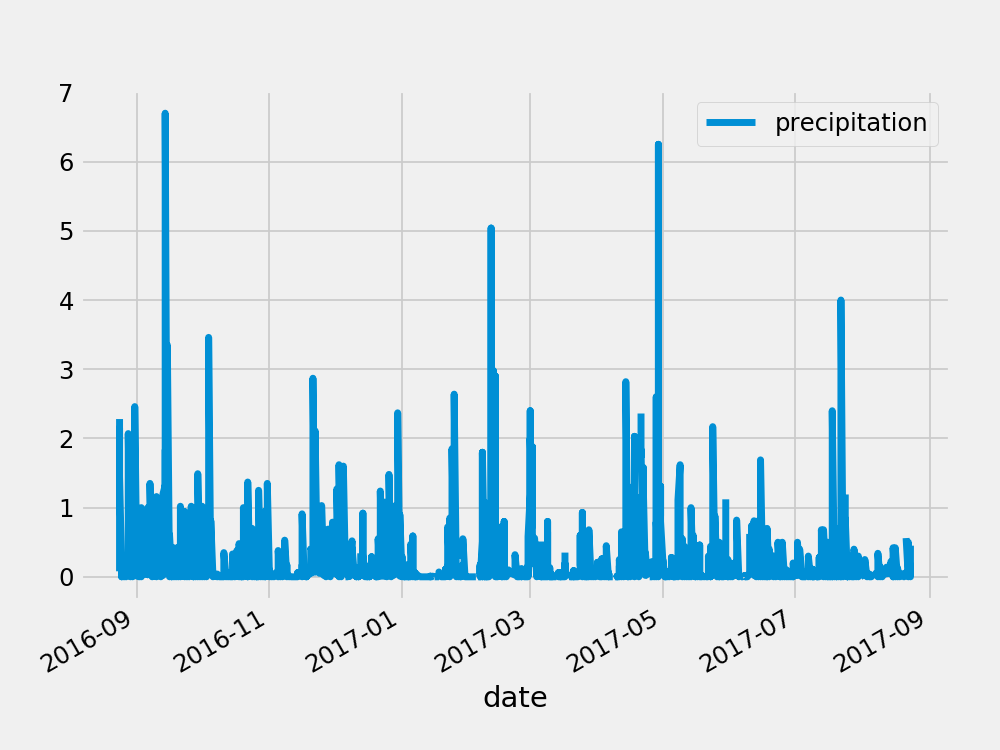

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_date_df.plot('date','precipitation',figsize=(8,6))


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_date_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# How many stations are available in this dataset?
num_stations = session.query(
    func.count(Station.id)
).all()
num_stations

[(9)]

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
active_station = session.query(
    Measurement.station,
    func.count(Measurement.id)
).group_by(
    Measurement.station
).order_by(
    func.count(Measurement.id).desc()
).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_record = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(
    Measurement.station == active_station[0][0]
).all()
station_record

[(54.0, 85.0, 71.66378066378067)]

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_month_tobs = session.query(
    Measurement.tobs,
    Measurement.date    
).filter(
    Measurement.date > first_date,
    Measurement.station == active_station[0][0]
).all()

In [17]:
tobs_df = pd.DataFrame(twelve_month_tobs,columns = ['tobs','date'])
tobs_df.head()

,tobs,date
0,77.0,2016-08-24
1,80.0,2016-08-25
2,80.0,2016-08-26
3,75.0,2016-08-27
4,73.0,2016-08-28


<IPython.core.display.Javascript object>


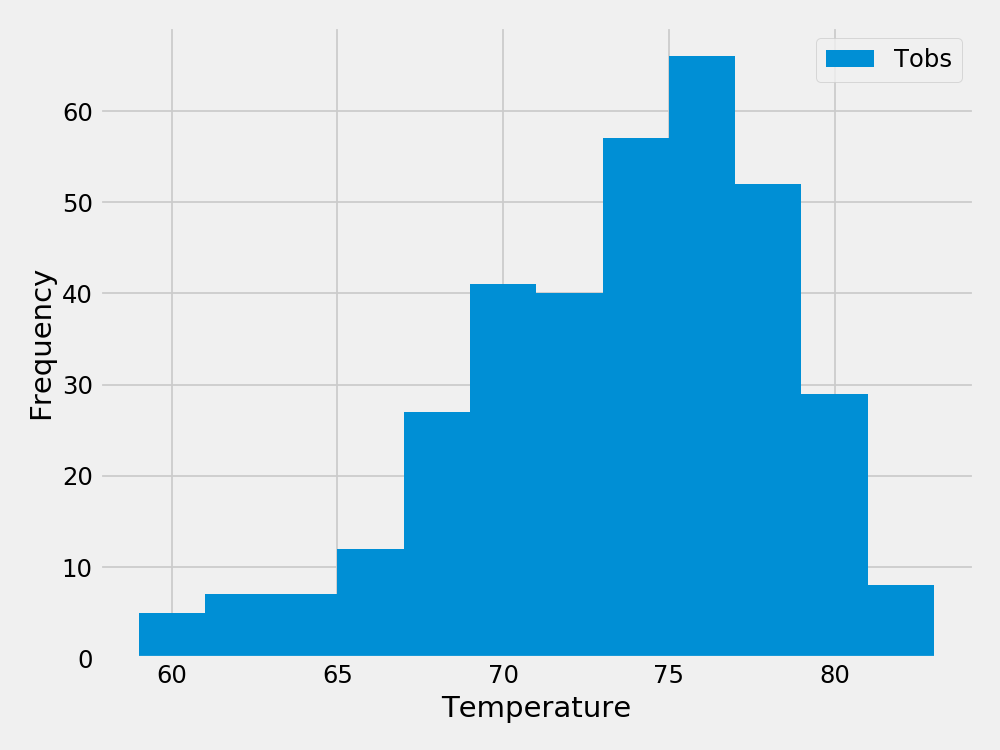

In [18]:
plt.figure(figsize=(8,6))
plt.hist(tobs_df['tobs'],bins = 12)
plt.legend(['Tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
prev_year_start = dt.date(2017, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 1, 7) - dt.timedelta(days=365)
print(prev_year_end)
print(prev_year_start)

2016-01-08
2016-01-02


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps(prev_year_start,prev_year_end)
tmin,tavg,tmax = temps[0]

<IPython.core.display.Javascript object>


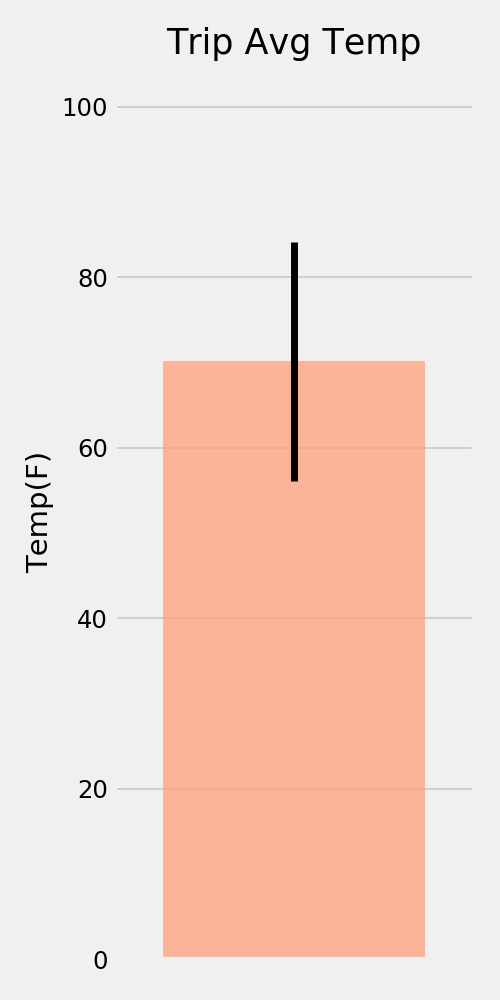

(0, 105)

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = tmax - tmin
xpos = 1
height = tavg
plt.figure(figsize=(4,8))
plt.bar(xpos,height,yerr=error,alpha = 0.75,color = 'lightsalmon')
plt.xticks([])
plt.yticks(np.arange(0,120,20))
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.tight_layout()
plt.xlim(0.45,1.55)
plt.ylim(0,105)

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_prcp = session.query(
    Station.station,
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation,
    func.avg(Measurement.prcp)
).filter(
    Measurement.station == Station.station,
    Measurement.date.between(prev_year_start,prev_year_end)
).group_by(
    Station.station
).order_by(
    func.avg(Measurement.prcp).desc()
).all()
print(station_prcp)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.42000000000000004), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.13285714285714284), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.07714285714285715), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03142857142857143), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.027142857142857142), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.026000000000000002), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
prev_year_start_two = dt.date(2018, 1, 1)
prev_year_end_two = dt.date(2018, 1, 7)
# Use the start and end date to create a range of dates
date_range = pd.date_range(prev_year_start_two,prev_year_end_two)
# Stip off the year and save a list of %m-%d strings
date_list = [d.strftime('%m-%d') for d in date_range]
# Loop through the list of %m-%d strings and calculate the normals for each date
normal_temp = [daily_normals(d)[0] for d in date_list]
normal_temp   

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_temp_df = pd.DataFrame(normal_temp,columns = ['tmin','tavg','tmax'],index=date_range)
normal_temp_df.index.name = 'date'
normal_temp_df

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


<IPython.core.display.Javascript object>


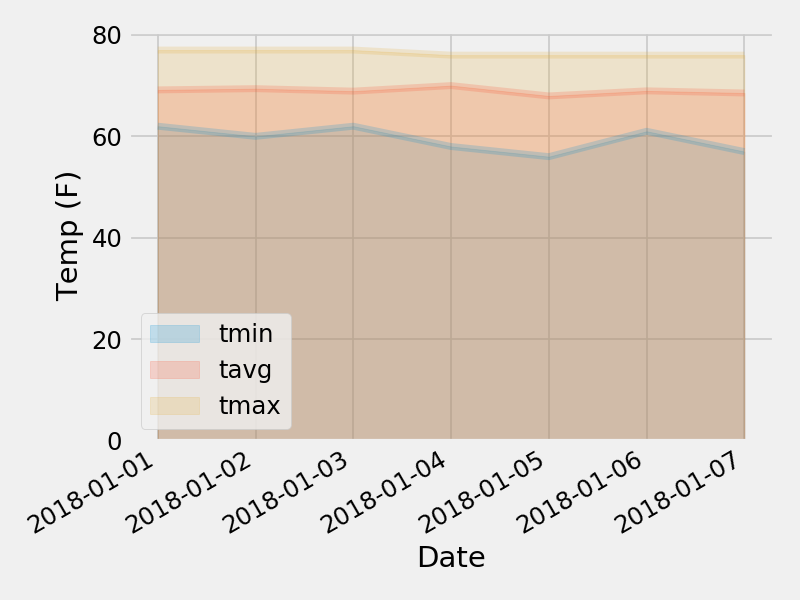

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots()
normal_temp_df.plot(kind = 'area',stacked = False,alpha =0.2, ax=ax)
plt.xlabel('Date')
plt.ylabel('Temp (F)')
plt.minorticks_off()
ax.xaxis.set_ticklabels(normal_temp_df.index.date, rotation=30, ha='right')
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.tight_layout()
plt.show()